In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential


## Loading dataset

In [ ]:
df = pd.read_csv("card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


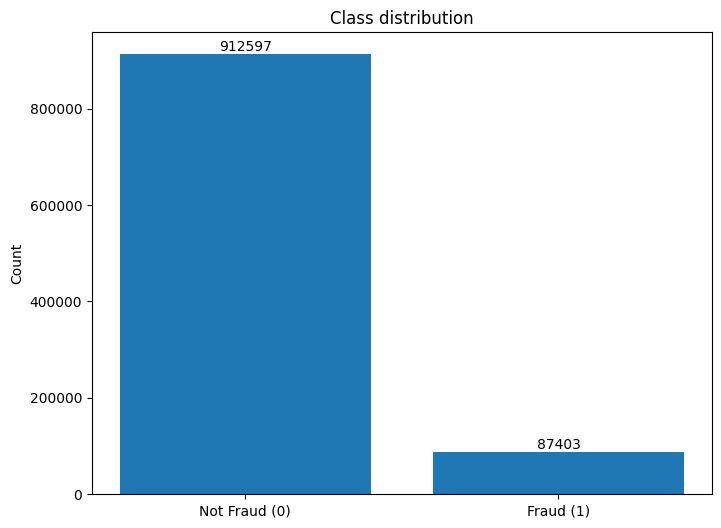

In [11]:
plt.figure(figsize=(8,6))
plt.bar(df["fraud"].value_counts().index, df["fraud"].value_counts().values)
plt.xticks([0, 1], ['Not Fraud (0)', 'Fraud (1)'])
plt.title("Class distribution")
plt.ylabel("Count")
counts = df["fraud"].value_counts()
for i, value in enumerate(counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

In [12]:
df["fraud"].value_counts().values/len(df["fraud"])

array([0.912597, 0.087403])

## Separating training and testing data

In [13]:
classes = df.iloc[:,-1]
data = df.iloc[:,:-1]

data = (data - data.min()) / (data.max() - data.min())

X_train, X_test, y_train, y_test = train_test_split(data,classes, test_size = 0.2, random_state= 14)

In [14]:
not_fraud_x_train = X_train[y_train == 0]
fraud_x_train = X_train[y_train == 1]

not_fraud_x_test = X_test[y_test == 0]
fraud_x_test = X_test[y_test == 1]

## Create autoencoder model

In [15]:
latent_dim = 2
input_dim = X_train.shape[1]

# Encoded
encoded_input = Input(shape=(input_dim,))
encoded = Dense(64, activation = 'relu')(encoded_input)
encoded = BatchNormalization()(encoded)
encoded = Dense(16, activation = 'relu')(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)
encoder = Model(encoded_input, encoded, name='encoder')

# Decoded
decoded_input = Input(shape = (latent_dim,))
decoded = Dense(16, activation = 'relu')(decoded_input)
decoded = Dense(64, activation = 'relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(input_dim, activation = 'sigmoid')(decoded)
decoder = Model(decoded_input, decoded, name = 'decoder')

# Autoencoder
autoencoder_input = Input(shape = (input_dim,))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)
autoencoder = Model(autoencoder_input, decoded, name = 'autoencoder')

autoencoder.compile(optimizer = 'adam', loss = 'mse')

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,842 (7.20 KB)

 Trainable params: 1,714 (6.70 KB)

 Non-trainable params: 128 (512.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,847 (7.21 KB)

 Trainable params: 1,719 (6.71 KB)

 Non-trainable params: 128 (512.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │         1,842 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 7)              │         1,847 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,689 (14.41 KB)

 Trainable params: 3,433 (13.41 KB)

 Non-trainable params: 256 (1.00 KB)

## Fitting

In [16]:
history = autoencoder.fit(not_fraud_x_train, not_fraud_x_train,
                         epochs = 20,
                         batch_size = 128,
                         validation_data = (not_fraud_x_test, not_fraud_x_test),
                         shuffle = True)

Epoch 1/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0169 - val_loss: 0.0026
Epoch 2/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0014 - val_loss: 4.7939e-04
Epoch 3/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 4.5989e-04 - val_loss: 4.7915e-04
Epoch 4/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 4.4829e-04 - val_loss: 4.7911e-04
Epoch 5/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 4.7587e-04 - val_loss: 4.7927e-04
Epoch 6/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 4.3844e-04 - val_loss: 4.7940e-04
Epoch 7/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 4.6173e-04 - val_loss: 4.7911e-04
Epoch 8/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 4.5512e-04 - val_loss: 4.7910e-04
Epoch 9/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 4.6076e-04 - val_loss: 4.7912e-04
Epoch 10/20
5705/5705 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 4.3226e-04 - val_loss: 4.7919e-04
Epoch 11/20
5705/5705 ━━━━━━━━━━━━━━━━━━━

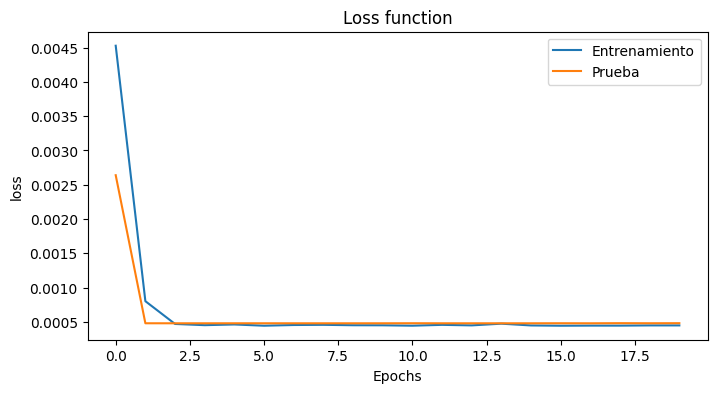

In [17]:
plt.figure(figsize= (8, 4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 784us/step


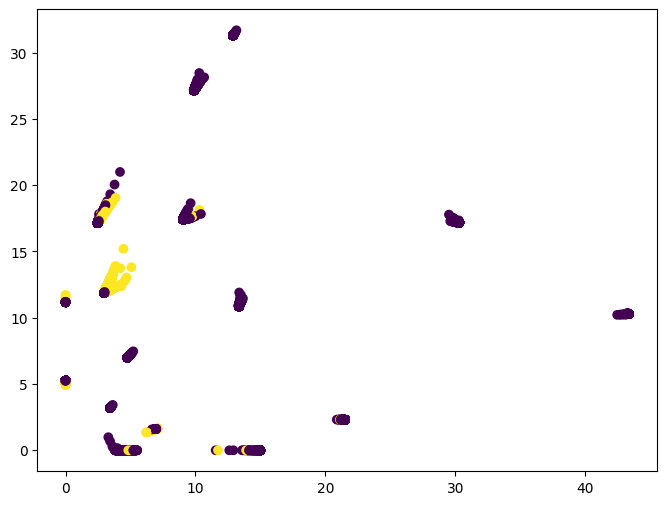

In [18]:
latent_space = encoder.predict(X_test)
plt.figure(figsize = (8,6))
plt.scatter(latent_space[:,0], latent_space[:,1], c = y_test)
plt.show()

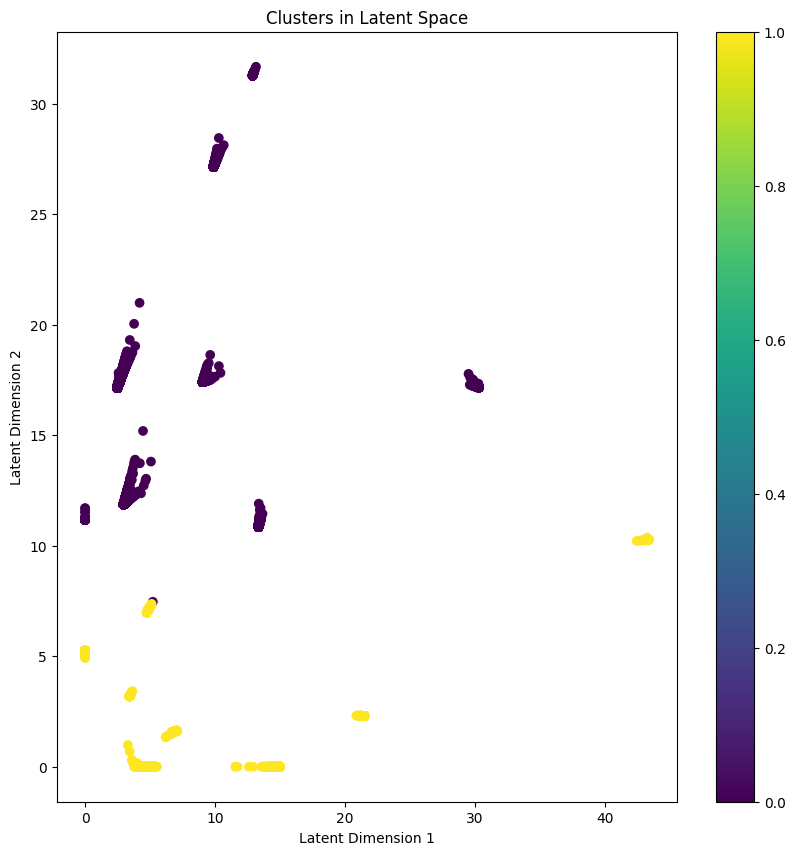

In [19]:
from sklearn.cluster import KMeans
# Aplicar K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(latent_space)

# Asignar etiquetas basadas en los clusters
#df['cluster'] = clusters

# Visualizar los clusters
plt.figure(figsize=(10, 10))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Clusters in Latent Space')
plt.show()

5703/5703 ━━━━━━━━━━━━━━━━━━━━ 5s 835us/step


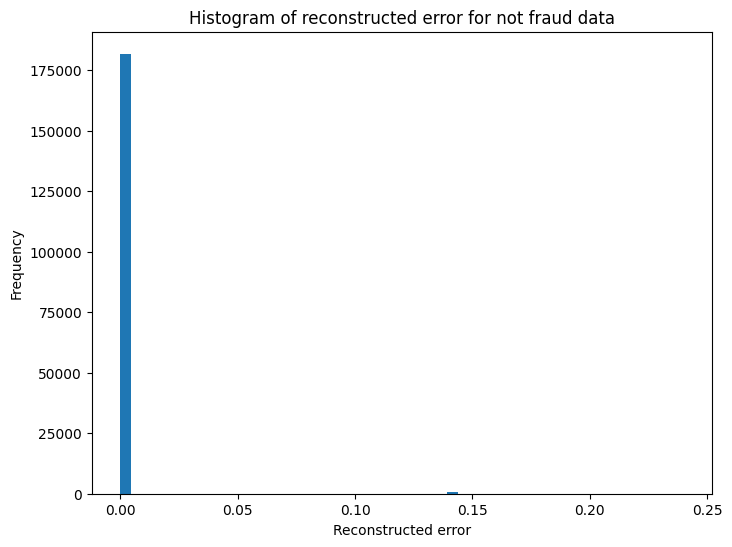

In [20]:
reconstructed_not_fraud_test = autoencoder.predict(not_fraud_x_test)
mse_not_fraud_test = np.mean(np.square(not_fraud_x_test - reconstructed_not_fraud_test), axis = 1)

plt.figure(figsize=(8, 6))
plt.hist(mse_not_fraud_test, bins=50)
plt.title('Histogram of reconstructed error for not fraud data')
plt.xlabel('Reconstructed error')
plt.ylabel('Frequency')
plt.show()

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


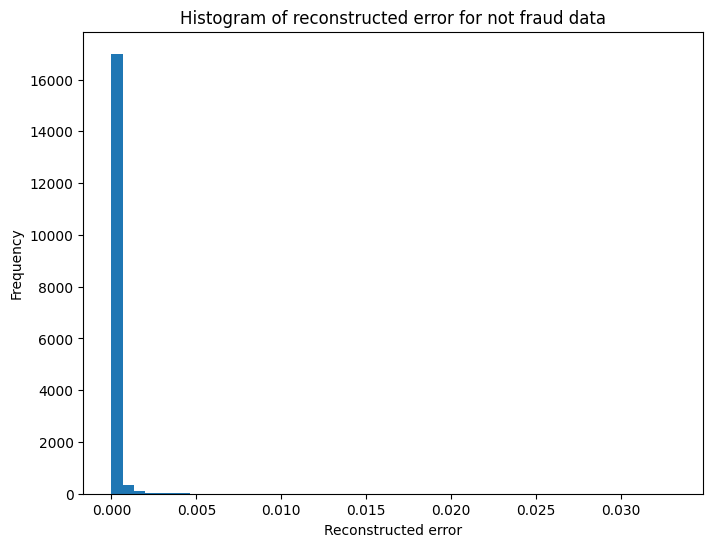

In [21]:
reconstructed_fraud_test = autoencoder.predict(fraud_x_test)
mse_fraud_test = np.mean(np.square(fraud_x_test - reconstructed_fraud_test), axis = 1)

plt.figure(figsize=(8, 6))
plt.hist(mse_fraud_test, bins=50)
plt.title('Histogram of reconstructed error for not fraud data')
plt.xlabel('Reconstructed error')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Aplicamos estandarización
scaler = StandardScaler()
mse_not_fraud_test = scaler.fit_transform(mse_not_fraud_test.values.reshape(1, -1))  # Se necesita una matriz de 2D
mse_fraud_test = scaler.fit_transform(mse_fraud_test.values.reshape(1,-1))


plt.figure(figsize=(8, 6))
plt.hist(mse_not_fraud_test, bins=50)
plt.hist(mse_fraud_test, bins = 50)
plt.title('Histogram of reconstructed error for not fraud data')
plt.xlabel('Reconstructed error')
plt.ylabel('Frequency')
plt.show()

KeyboardInterrupt: 

In [ ]:
np.array(mse_fraud_test.values)